# Rabi oscillations

Imagine that you have a two-level system in your lab that you want to use as your qubit. To verify that you prepared it well, you can perform a Rabi experiment! 

In this notebook, you will ...
* ... understand how the populations of the two states of a qubit behave when the qubit is driven by a resonant pulse.

By the end of this notebook, you will not only have a basic understanding of how to execute pulse schedules, but you will also have a feeling for the outcome to expect in your experiments.

In order to get started, make sure you have the appropriate packages installed:

In [ ]:
%%capture 
!pip install iqm-client
!pip install iqm-pulla 
!pip install matplotlib
!pip install pylatexenc

## 1. Preparation

### 1.1 Connecting to the QPU station control
In the following, we will use the PulLa (Pulse Level Access) package. You can find the documentation [here](https://docs.meetiqm.com/iqm-pulla/).

As a first step, we need to create a **PulLa object**. In general, this is a **compiler**, in a particular state, linked to a particular quantum computer. It contains calibration data and the set of available operations. 

Make sure you have the correct url and token below.

In [1]:
from iqm.pulla.pulla import Pulla
import os
from iqm.iqm_client.authentication import TokenManager

# On-premise
#os.environ["IQM_TOKENS_FILE"]="your-token-here"
#p = Pulla("your-url-here", get_token_callback=TokenManager().get_bearer_token) 

#Resonance 
api_token = input()
p = Pulla("https://cocos.resonance.meetiqm.com/sirius", get_token_callback=lambda: api_token) 

compiler = p.get_standard_compiler()

/Users/see/miniforge3/envs/pulla/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Driving qubits
In a superconducting QPU, we control qubits via microwave pulses sent via the **qubit drive lines**. If we apply the driving pulse for a time *t*, the qubit oscillates between the two states $|0\rangle$ and $|1\rangle$. This behaviour is known as the **Rabi cycle** of the qubit. The unitary operator that leads to this result is called **Rabi driving** and can be written as:
$$U(t)= e^{-\frac{i}{2} \Theta(t) \sigma_x}$$
where $\sigma_x$ is the $x$-Pauli matrix and $\Theta(t)\propto\int_0^t{s(t')dt'}$, with $s(t)$ the waveform envelope. This gives that the angle by which a state is rotated is proportional to the time integral of the pulse.

### 2.1 Implementation
In our QPU, we can perform the operation above with a PRX gate (definition [here](https://docs.meetiqm.com/iqm-pulse/api/iqm.pulse.gates.prx.html#module-iqm.pulse.gates.prx)).

While the exact **shape** of the drive pulse can vary, all pulses are parametrized to have an `amplitude_i` and a `full_width`.
Increasing either of these will rotate the state of the qubit by a larger amount. The parameter `amplitude_i` is restricted to values in the interval $[-1,1]$, whereas `full_width` can be anything.

In addition, all gates have a `duration` parameter, which determines the time window in which the pulse waveform must fit.
`duration` can only take values that the hardware supports and can be retrieved from the calibration data:

You can check the different calibrated implementations of the PRX gate using the code below. If needed, you can change the `default_impl` parameter in the following.

In [ ]:
print(compiler.gates["prx"].implementations.keys())

In [2]:
calibration = compiler.get_calibration()
default_impl = 'drag_crf'
print("duration (s) = ", calibration[f"gates.prx.{default_impl}.{'QB1'}.duration"])

duration (s) =  4e-08


### 2.2 Preparing the circuits

We select a physical qubit on the QPU and we make multiple variations of the same base circuit: **Play a pulse and measure**. 

First, let's check the calibrated values of the amplitude and width for the PRX gate:

In [3]:
qubit = "QB1"
print("amplitude = ", calibration[f"gates.prx.{default_impl}.{qubit}.amplitude_i"])
print("full width = ", calibration[f"gates.prx.{default_impl}.{qubit}.full_width"])

amplitude =  0.4445816793018683
full width =  4e-08


We now define the two intervals for the amplitude and width of the pulse and the number of steps, keeping in mind the allowed values mentioned above.

In [4]:
import numpy as np

width_axis = np.linspace(1e-9, 80e-9, 20)
amplitude_axis = np.linspace(0, 0.5, 25)

We use the IQM Pulse syntax to define the circuits (see documentation [here](https://docs.meetiqm.com/iqm-pulse/)). 

First, we need to define our custom `drive_pulse` operation and register it such that the compiler is able to recognize it when running the circuits. To do that, we use the `CompositeGate` class:


In [5]:
from iqm.pulse.gate_implementation import CompositeGate

class CustomPulse(CompositeGate):
    # GateImplementation for our custom gate.
    # It uses the calibration for the regular "measure", but replaces the calibrated frequency.

    def _call(self, amplitude: float, width: float):
        # This will be called when "custom_measure" is encountered during circuit compilation.
        priority_calibration = {
            "amplitude_i": amplitude,
            "full_width": width,
            "duration": width_axis[-1],
        }
        modded_prx = self.builder.prx(self.locus, priority_calibration=priority_calibration, impl_name="drag_crf")
        return modded_prx(np.pi, 0)
    
compiler.add_implementation(
    op_name="drive_pulse",
    implementation=CustomPulse,
    impl_name="custom_pulse",
    quantum_op_specs={"params": ("amplitude", "width")},
    overwrite=True
)

Above, we set the `duration` of the gate equal to the biggest width in your interval.

We can now create a *batch* of circuits containing a drive pulse with different parameters and a measurement. We can then submit it as a single job.

In [6]:
from iqm.cpc.interface.compiler import Circuit, CircuitOperation as Op

circuits = []
for width in width_axis:
    for amplitude in amplitude_axis:
        circuit = Circuit("Rabi test", [
            Op("drive_pulse", (qubit,), args={"amplitude": amplitude, "width": width}),  
            Op("measure", (qubit,), args={"key": "M"})    
        ])
        circuits.append(circuit)

Let's run the *playlist* created above! You can change the number of shots for the measurement, taking into account that the run time of the execute below might vary.

In [7]:
playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=500)
settings.options.averaging_bins = 1  

In [10]:
# Warning: this could take ~2 minutes to run 
job = p.execute(playlist, context, settings, verbose=False)

[04-24 09:33:58;I] Submitted sweep with ID: 019666b7-b805-7c43-947f-86346257fa5d
[04-24 09:33:58;I] Created task in queue with ID: 019666b7-b805-7c43-947f-86346257fa5d
[04-24 09:33:58;I] Waiting for the sweep to finish...


Progress in queue: 100%|██████████| 1/1 [01:40<00:00, 100.12s/it]


[04-24 09:35:39;I] Sweep status: SweepStatus.SUCCESS


## 3. Analyze the results

Now that the job is complete, we can retrieve the results.

As explained above, in a Rabi experiment, we expect to see oscillations between the two states of the qubit. To see this, we need to plot the transition probability as a function of time (width) and amplitude of the drive pulse:

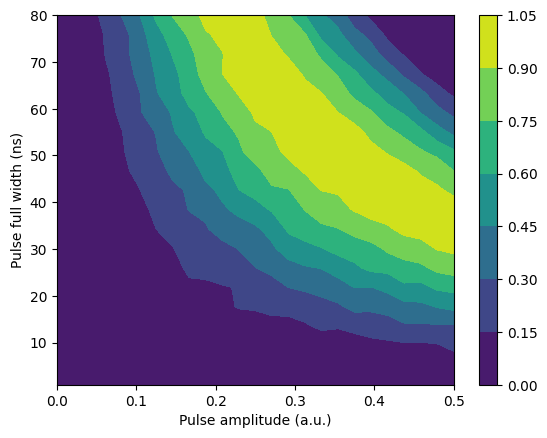

In [11]:
import matplotlib.pyplot as plt

probability = np.array([data["M"] for data in job.result])
probability = probability.reshape((len(width_axis), len(amplitude_axis)))

plt.figure()
ax = plt.contourf(amplitude_axis, width_axis / 1e-9, probability)
plt.gcf().colorbar(ax)
plt.xlabel("Pulse amplitude (a.u.)")
plt.ylabel("Pulse full width (ns)");

Congratulations, you have a qubit! 🎉 We can see the oscillations of the states' populations.

More precisely, the transition probability from the $|0\rangle$ state to the $|1\rangle$ state is given by:
$$P_{0\rightarrow 1}(t) = \sin^2{\frac{\omega t}{2}}$$

where $\omega$ is called the *Rabi frequency*.

In [ ]:
# Copyright 2025 IQM Quantum Computers (Joni Ikonen, Nadia Milazzo)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.